In [ ]:
import pymysql.cursors
import pandas as pd
from datetime import datetime, timedelta
import calendar
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [ ]:
#import pyodbc
#conn = pyodbc.connect("DRIVER={{ODBC Driver 17 for SQL Server}};SERVER={0}; database={1};UID={2};PWD={3}".format('10.20.2.110,1433','AIG_DARAZ_PK_DW','daraz-tools','JfF7ziSCNk5jPxd'))
#cursor = conn.cursor()

#query = open('SqlForDailyDemandData.sql', 'r')
#dataFrame_initial = pd.read_sql_query(query.read(), conn)
#dataFrame_initial.shape

In [ ]:
#dataFrame_initial.to_pickle('./dataFile',compression='infer', protocol=4)

In [ ]:
df_initial = pd.read_pickle('./dataFile', compression='infer')

In [ ]:
#df_initial.dtypes

In [ ]:
#query = open('ProductVisibility.sql', 'r')
#df_prodVisible = pd.read_sql_query(query.read(), conn)
#df_prodVisible.shape

In [ ]:
#df_prodVisible.to_pickle('./productVisibilityDataFile',compression='infer', protocol=4)
df_prodVisible = pd.read_pickle('./productVisibilityDataFile', compression='infer')


In [ ]:
#df_prodVisible[df_prodVisible.DD_COD_SKU_CONFIG == '10259FA03RQUYNAFAMZ']['2018-02-10'].head()

In [ ]:
df_initial['date'] = pd.to_datetime(df_initial['date'])
df_initial.sort_values(by='date').head()

In [ ]:
#df_initial['DSC_PRODUCT_WEIGHT'].unique()

In [ ]:
# import re
# df_initial['DSC_PRODUCT_WEIGHT'] = df_initial['DSC_PRODUCT_WEIGHT'].apply(lambda x : re.sub(r'#', r'0', str(x)))
# df_initial['DSC_PRODUCT_WEIGHT'] = df_initial['DSC_PRODUCT_WEIGHT'].apply(lambda x : re.sub(r'[a-zA-Z]', '', str(x)))
# df_initial['DSC_PRODUCT_WEIGHT'] = df_initial['DSC_PRODUCT_WEIGHT'].apply(lambda x : re.sub(r'([.])\1+', r'\1', str(x)))
# df_initial['DSC_PRODUCT_WEIGHT'] = df_initial['DSC_PRODUCT_WEIGHT'].apply(lambda x : re.sub(r'/', r'', str(x)))
# df_initial['DSC_PRODUCT_WEIGHT'] = df_initial['DSC_PRODUCT_WEIGHT'].apply(lambda x : re.sub(r'[!]', '0', str(x)))
# df_initial['DSC_PRODUCT_WEIGHT'] = pd.to_numeric(df_initial['DSC_PRODUCT_WEIGHT'])


In [ ]:
#df_initial.describe()

In [ ]:
#df_initial[df_initial.DSC_PRODUCT_WEIGHT == df_initial['DSC_PRODUCT_WEIGHT'].max()]

In [ ]:
df_initial['CatConcat'] = df_initial[['DSC_CATEGORY_NAME_LEVEL_1', 'DSC_CATEGORY_NAME_LEVEL_2','DSC_CATEGORY_NAME_LEVEL_3','DSC_CATEGORY_NAME_LEVEL_4']].apply(lambda x: ' '.join(x.str.strip()), axis=1)

In [ ]:
#df_initial[df_initial.CatConcat == "Grocer's Shop Cooking Essentials Rice, Flours, Pulses & Grains Rice"]['DSC_PRODUCT_NAME'].value_counts()[:10]

In [ ]:
# df_initial[df_initial.DSC_PRODUCT_NAME == 'Super Kernel Basmati Rice']['COD_SKU_CONFIG'].value_counts()

In [ ]:
# df_initial[(df_initial.DSC_PRODUCT_NAME == 'Super Kernel Basmati Rice') &
#            (df_initial.DSC_PRODUCT_BRAND_NAME_EN == 'Xidmat')]['date'].max()

In [ ]:
# newDf = df_initial[(df_initial.COD_SKU_CONFIG == 'RE775OT1GWF5GNAFAMZ')]['date'].to_frame()

# newDf['CummulativeQuantity'] = df_initial[(df_initial.COD_SKU_CONFIG == 'RE775OT1GWF5GNAFAMZ')]['Valid Total'].cumsum()

# newDf['DemandPercent'] = (newDf['CummulativeQuantity']/newDf['CummulativeQuantity'].iloc[-1])*100

In [ ]:
#df_initial[(df_initial.COD_SKU_CONFIG == SKUid)].head()

In [ ]:
#newDf[40:105]

In [ ]:
# plt.figure(figsize=(10,7))
# plt.plot(newDf.date, newDf.DemandPercent)
# plt.ylabel('Percentage Demand', fontsize=12)
# plt.xlabel('Date', fontsize=12)

In [ ]:
df_prodVisible = df_prodVisible.fillna(0)

df_prodVisible = df_prodVisible.T

In [ ]:
df_prodVisible.columns = df_prodVisible.iloc[0]

df_prodVisible = df_prodVisible.reindex(df_prodVisible.index.drop('DD_COD_SKU_CONFIG'))

In [ ]:
df_prodVisible['2018-03-04':'2018-03-06'][['00301FA0IW7BMNAFAMZ']]

In [ ]:
def zero_runs(a):
    # Create an array that is 1 where a is 0, and pad each end with an extra 0.
    iszero = np.concatenate(([0], np.equal(a, 0).view(np.int8), [0]))
    absdiff = np.abs(np.diff(iszero))
    # Runs start and end where absdiff is 1.
    ranges = np.where(absdiff == 1)[0].reshape(-1, 2)
    return ranges

In [ ]:
def getOfflineData(offlineRaw,SKU_name):
    dataFrame = pd.DataFrame()
    for ind, column in enumerate(offlineRaw.columns):
        runs = zero_runs(offlineRaw.iloc[:,ind])
        tuples = zip(offlineRaw.iloc[runs[:,0],0].index, runs[:,1] - runs[:,0])
        tempDf = {}
        cols = ['OfflineDate','OfflineDays']
        tuples = list(tuples)
        tempDf = pd.DataFrame.from_records(tuples,columns = cols)
        tempDf['SKU'] = column
        dataFrame = dataFrame.append(tempDf)
    return dataFrame
        

In [ ]:
#formattedDf = getOfflineData(df_prodVisible,df_prodVisible.columns.values[0])
#formattedDf.to_pickle('./OfflineFormattedData',compression='infer', protocol=4)
formattedDf = pd.read_pickle('./OfflineFormattedData', compression='infer')
#formattedDf.head()

In [ ]:
#Sample SKUs 00301FA0IW7BMNAFAMZ, 00301FA1IM7MANAFAMZ, 10259FA0074AYNAFAMZ
#formattedDf['OfflineDate'] = pd.to_datetime(formattedDf['OfflineDate'])
#df_initial.dtypes

### Offline Product Similarity Match 

In [ ]:
SKUid = '10259FA00UP2INAFAMZ'

In [ ]:
PeriodStartDate = '2018-03-07'
categoryName = df_initial[df_initial.COD_SKU_CONFIG == SKUid]['CatConcat'].unique()
print("Concatenated Category Name : ", categoryName)
productame = df_initial[df_initial.COD_SKU_CONFIG == SKUid]['DSC_PRODUCT_NAME'].unique()
print("Product Name : ",productame)
brandName = df_initial[df_initial.COD_SKU_CONFIG == SKUid]['DSC_PRODUCT_BRAND_NAME_EN'].unique()
print("Brand : " ,brandName)
offlineStartDate = formattedDf[formattedDf.SKU == SKUid].iloc[3:4,0].values[0]
print("Offline Start Date : ", offlineStartDate)

offlineDays = formattedDf[formattedDf.SKU == SKUid].iloc[3:4,1].values[0]
print("Stayed offline for # of Days : ", offlineDays)

relevantSkuList = df_initial[(df_initial.CatConcat == categoryName[0]) & (df_initial.COD_SKU_CONFIG != SKUid)]['COD_SKU_CONFIG'].unique()
#print('SKUs which have been sold during this period from this relevent category cluster ',len(relevantSkuList))

#print('No of records in this Category, whose demand data we have in our date range of 5 months:',len(df_initial[(df_initial.CatConcat == categoryName[0]) & (df_initial.COD_SKU_CONFIG != '00301FA0IW7BMNAFAMZ')].index))

In [ ]:
#df_prodVisible[np.intersect1d(df_prodVisible.columns, list(relevantSkuList))].head()
#df_prodVisible[df_prodVisible.columns.intersection(list(relevantSkuList))].head()

formattedDf[formattedDf.SKU == SKUid]

In [ ]:
releventSKUdataFrame = df_prodVisible[(datetime.strptime(PeriodStartDate, "%Y-%m-%d").strftime("%Y-%m-%d")) : (datetime.strptime(offlineStartDate, "%Y-%m-%d") + timedelta(days=int(offlineDays)-1)).strftime("%Y-%m-%d")]

releventSKUdataFrame = releventSKUdataFrame[releventSKUdataFrame.columns.intersection(list(relevantSkuList))].apply(pd.Series.value_counts)

In [ ]:
releventSKUdataFrame

In [ ]:
findOnlineRelatedSKUs = releventSKUdataFrame

In [ ]:
findOnlineRelatedSKUs = findOnlineRelatedSKUs.T

In [ ]:
if findOnlineRelatedSKUs.shape[1] == 2:
     findOnlineRelatedSKUs.columns = ['Off', 'On']
else:
     findOnlineRelatedSKUs.columns = ['On']

In [ ]:
findOnlineRelatedSKUs.shape

In [ ]:
#Get SKUs from the smilar valid SKU list which were OnLine atleast
similarSKU4DC = findOnlineRelatedSKUs[findOnlineRelatedSKUs["On"] > 0].index
len(similarSKU4DC)

In [ ]:
demandCurveDf = df_initial[df_initial.COD_SKU_CONFIG.isin(similarSKU4DC)]
demandCurveDf = demandCurveDf[(demandCurveDf.date >= datetime.strptime(PeriodStartDate, "%Y-%m-%d")) 
             & (demandCurveDf.date <= datetime.strptime(offlineStartDate, "%Y-%m-%d") + timedelta(days=int(offlineDays)-1))]
#demandCurveDf = demandCurveDf['date'].to_frame()
demandCurveDf.shape

In [ ]:
if demandCurveDf.shape[0] > 0:
    temp = pd.DataFrame(demandCurveDf.groupby(['date'])['Valid Total'].mean()).reset_index()
    demandCurveDf = temp['date'].to_frame()
    demandCurveDf['CummulativeQuantity'] = temp['Valid Total'].cumsum().round(1)
    demandCurveDf['DemandPercent'] = (demandCurveDf['CummulativeQuantity']/demandCurveDf['CummulativeQuantity'].iloc[-1])*100

In [ ]:
demandCurveDf.tail(10)

In [ ]:
temp = df_initial[df_initial.COD_SKU_CONFIG == SKUid]
temp = temp[(temp.date >= datetime.strptime(PeriodStartDate, "%Y-%m-%d")) 
                     & (temp.date <= datetime.strptime(offlineStartDate, "%Y-%m-%d") + timedelta(days=int(offlineDays)-1))]

if temp['COD_SKU_CONFIG'].count() > 0:
    onlineDemand = 1
    demandCurveDf4Offline = temp['date'].to_frame()
    demandCurveDf4Offline['CummulativeQuantity'] = temp[(temp.COD_SKU_CONFIG == SKUid)]['Valid Total'].cumsum()
    demandCurveDf4Offline['DemandPercent'] = (demandCurveDf4Offline['CummulativeQuantity']/demandCurveDf4Offline['CummulativeQuantity'].iloc[-1])*100
    print(demandCurveDf4Offline)
    #print("Recorded demand during Online period : ",temp['COD_SKU_CONFIG'].count())
else:
    onlineDemand = 0
    print("No Demand Recorded during Online period")

In [ ]:
if onlineDemand > 0:
    if (datetime.strptime(offlineStartDate, "%Y-%m-%d") > demandCurveDf4Offline[demandCurveDf4Offline.DemandPercent == 100]['date']).values[0]:
        dateOfOFFLine = offlineStartDate
    else:
        dateOfOFFLine = demandCurveDf4Offline[demandCurveDf4Offline.DemandPercent == 100]['date'].values[0]
    if int(offlineDays) > 1:
        DemandPercentWhenSoldOut = demandCurveDf[demandCurveDf.date <= dateOfOFFLine].tail(1)['DemandPercent']/100
    else:
        DemandPercentWhenSoldOut = demandCurveDf[demandCurveDf.date <= dateOfOFFLine][-2:-1]['DemandPercent']/100
    if DemandPercentWhenSoldOut.count() == 0:
        print("Estiamted Lost Sales (Category SO) :",DemandPercentWhenSoldOut.count())
    else:
        CummulativeQuantityWhenSoldOut = demandCurveDf4Offline[demandCurveDf4Offline.DemandPercent == 100]['CummulativeQuantity']
        print("Cummulative Quantity When Sold Out:",CummulativeQuantityWhenSoldOut.values[0])
        print("Demand Percent of Category when the product went offline ",DemandPercentWhenSoldOut.values[0])
        EstiamtedLostSales = CummulativeQuantityWhenSoldOut/DemandPercentWhenSoldOut.values[0]
        print("Estiamted Lost Sales :",(EstiamtedLostSales.values[0] - CummulativeQuantityWhenSoldOut).values[0])

In [ ]:
plt.figure(figsize=(10,7))
markers_on = [DemandPercentWhenSoldOut.index[0]]
plt.plot(demandCurveDf.date, demandCurveDf.DemandPercent,'-bX',markevery=markers_on)

for a,b in zip(demandCurveDf.date, demandCurveDf.DemandPercent): 
    if( b == DemandPercentWhenSoldOut.values[0] * 100):
        plt.text(a, b, "Category Demand % : " + str(b) + "  \nDate : " + str(a))
        
plt.ylabel('Percentage Demand', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.suptitle('Demand Curve of Category Segment : ' + df_initial[df_initial.COD_SKU_CONFIG == SKUid]['CatConcat'].values[0], fontsize=18)
plt.title('Product Name: ' + df_initial[df_initial.COD_SKU_CONFIG == SKUid]['DSC_PRODUCT_NAME'].values[0], fontsize=14)


In [64]:
def getEstimatedLostSale(SKUName,startDate,offlineStartDate,offlineDays,ifPrint):
    
    if startDate == offlineStartDate:
        #print("Product Offline")
        return "Product Offline : " + str(datetime.strptime(startDate, "%Y-%m-%d")) + " - " + str(datetime.strptime(offlineStartDate, "%Y-%m-%d") + timedelta(days=int(offlineDays)-1))

    PeriodStartDate = startDate
    
    skuDemandCheckDf = df_initial[df_initial.COD_SKU_CONFIG == SKUName]

    skuDemandCheckDf = skuDemandCheckDf[(skuDemandCheckDf.date >= datetime.strptime(PeriodStartDate, "%Y-%m-%d")) 
                     & (skuDemandCheckDf.date <= datetime.strptime(offlineStartDate, "%Y-%m-%d") + timedelta(days=int(offlineDays)-1))]
     
    if skuDemandCheckDf['COD_SKU_CONFIG'].count() == 0:
        #print("No Demand")
        return "No Demand : " + str(datetime.strptime(startDate, "%Y-%m-%d")) + " - " + str(datetime.strptime(offlineStartDate, "%Y-%m-%d") + timedelta(days=int(offlineDays)-1))
    else:
        
        categoryName = df_initial[df_initial.COD_SKU_CONFIG == SKUName]['CatConcat'].unique()
        
        productame = df_initial[df_initial.COD_SKU_CONFIG == SKUName]['DSC_PRODUCT_NAME'].unique()
       
        brandName = df_initial[df_initial.COD_SKU_CONFIG == SKUName]['DSC_PRODUCT_BRAND_NAME_EN'].unique()
        
        relevantSkuList = df_initial[(df_initial.CatConcat == categoryName[0]) & (df_initial.COD_SKU_CONFIG != SKUName)]['COD_SKU_CONFIG'].unique()
       
        releventSKUdataFrame_ = df_prodVisible[(datetime.strptime(PeriodStartDate, "%Y-%m-%d").strftime("%Y-%m-%d")) : (datetime.strptime(offlineStartDate, "%Y-%m-%d") + timedelta(days=int(offlineDays)-1)).strftime("%Y-%m-%d")]

        releventSKUdataFrame_ = releventSKUdataFrame_[releventSKUdataFrame_.columns.intersection(list(relevantSkuList))].apply(pd.Series.value_counts)
        
        ##If no relevent products found ONLINE during this time period 
        if len(releventSKUdataFrame_) == 0:
            #print("Estiamted Lost Sales : Nothing 0")
            return '0'
        
        findOnlineRelatedSKUs = releventSKUdataFrame_
        
        findOnlineRelatedSKUs = findOnlineRelatedSKUs.T
        
        if findOnlineRelatedSKUs.shape[1] == 2:
             findOnlineRelatedSKUs.columns = ['Off', 'On']
        elif findOnlineRelatedSKUs.shape[1] == 1:
             findOnlineRelatedSKUs.columns = ['On']
        else :
            return "Error in calculation"
        #Get SKUs from the smilar valid SKU list which were OnLine atleast
        similarSKU4DC_ = findOnlineRelatedSKUs[findOnlineRelatedSKUs["On"] > 0].index
        
        demandCurveDf_ = df_initial[df_initial.COD_SKU_CONFIG.isin(similarSKU4DC_)]
        demandCurveDf_ = demandCurveDf_[(demandCurveDf_.date >= datetime.strptime(PeriodStartDate, "%Y-%m-%d")) 
             & (demandCurveDf_.date <= datetime.strptime(offlineStartDate, "%Y-%m-%d") + timedelta(days=int(offlineDays)-1))]
        
        ##When No data found for the relevent Category of the SKU of search
        if demandCurveDf_.shape[0] == 0:
            #print("Estiamted Lost Sales : Null 0")
            return 'Null 0'
        
        temp = pd.DataFrame(demandCurveDf_.groupby(['date'])['Valid Total'].mean()).reset_index()
        demandCurveDf_ = temp['date'].to_frame()
        demandCurveDf_['CummulativeQuantity'] = temp['Valid Total'].cumsum().round(1)
        demandCurveDf_['DemandPercent'] = (demandCurveDf_['CummulativeQuantity']/demandCurveDf_['CummulativeQuantity'].iloc[-1])*100
        #demandCurveDf
        
        #####Demand Curve for Offlined SKU
        demandCurveDf4Offline_ = skuDemandCheckDf['date'].to_frame()
        demandCurveDf4Offline_['CummulativeQuantity'] = skuDemandCheckDf[(skuDemandCheckDf.COD_SKU_CONFIG == SKUName)]['Valid Total'].cumsum()
        demandCurveDf4Offline_['DemandPercent'] = (demandCurveDf4Offline_['CummulativeQuantity']/demandCurveDf4Offline_['CummulativeQuantity'].iloc[-1])*100
        #demandCurveDf4Offline
        
        #demandCurveDf4Offline[demandCurveDf4Offline.DemandPercent == 100]['date'].values[0]
        #demandCurveDf4Offline
        #set_trace()
        if (datetime.strptime(offlineStartDate, "%Y-%m-%d") > demandCurveDf4Offline[demandCurveDf4Offline.DemandPercent == 100]['date']).values[0]:
            dateOfOFFLine = offlineStartDate
        else:
            dateOfOFFLine = demandCurveDf4Offline[demandCurveDf4Offline.DemandPercent == 100]['date'].values[0]

        if int(offlineDays) > 1:
            DemandPercentWhenSoldOut_ = demandCurveDf_[demandCurveDf_.date <= dateOfOFFLine].tail(1)['DemandPercent']/100
        else:
            DemandPercentWhenSoldOut_ = demandCurveDf_[demandCurveDf_.date <= dateOfOFFLine][-2:-1]['DemandPercent']/100
 
        ## for case when the Product Category last sold was lesser then the product SKU itself , so we can assume that 
        ## there is no LOST sale , since SKU was sold after the category Overall was already been soldout .
        ## example SKU and dates are 10259FA0924GYNAFAMZ and 4:5 Offline Record 
        
        if DemandPercentWhenSoldOut_.count() == 0:
            #print("Estiamted Lost Sales : None 0")
            return 'None 0';
        
        CummulativeQuantityWhenSoldOut_ = demandCurveDf4Offline_[demandCurveDf4Offline_.DemandPercent == 100]['CummulativeQuantity']
        
        EstiamtedLostSales_ = CummulativeQuantityWhenSoldOut_/DemandPercentWhenSoldOut_.values[0]
        print("---------------------------------------------------------------------------")
        print("SKU: ",SKUName ," Start Date ",startDate, " OfflineDate ", offlineStartDate , " Offline for Days ", offlineDays, "Demand % : ", DemandPercentWhenSoldOut_.values[0], "Total Demand when Offline : ", CummulativeQuantityWhenSoldOut_.values[0])
        print("Estiamted Lost Sales :", (EstiamtedLostSales_.values[0] - CummulativeQuantityWhenSoldOut_).values[0])
        
        if ifPrint:
            
            plt.figure(figsize=(10,7))
            markers_on = [DemandPercentWhenSoldOut_.index[0]]
            plt.plot(demandCurveDf_.date, demandCurveDf_.DemandPercent,'-bX',markevery=markers_on)

            for a,b in zip(demandCurveDf_.date, demandCurveDf_.DemandPercent):
                if( b == DemandPercentWhenSoldOut_.values[0] * 100):
                    plt.text(a, b, "Category Demand % : " + str(b) + "  \nDate : " + str(a))

            plt.ylabel('Percentage Demand', fontsize=12)
            plt.xlabel('Date', fontsize=12)
            plt.suptitle('Demand Curve of Category Segment : ' + df_initial[df_initial.COD_SKU_CONFIG == SKUName]['CatConcat'].values[0], fontsize=18)
            plt.title('Product Name: ' + df_initial[df_initial.COD_SKU_CONFIG == SKUName]['DSC_PRODUCT_NAME'].values[0], fontsize=14)

        
        return (EstiamtedLostSales_.values[0] - CummulativeQuantityWhenSoldOut_).values[0]


---------------------------------------------------------------------------
SKU:  10259FA00UP2INAFAMZ  Start Date  2018-03-07  OfflineDate  2018-03-09  Offline for Days  53 Demand % :  0.0546875 Total Demand when Offline :  1
Estiamted Lost Sales : 17.285714285714285


17.285714285714285

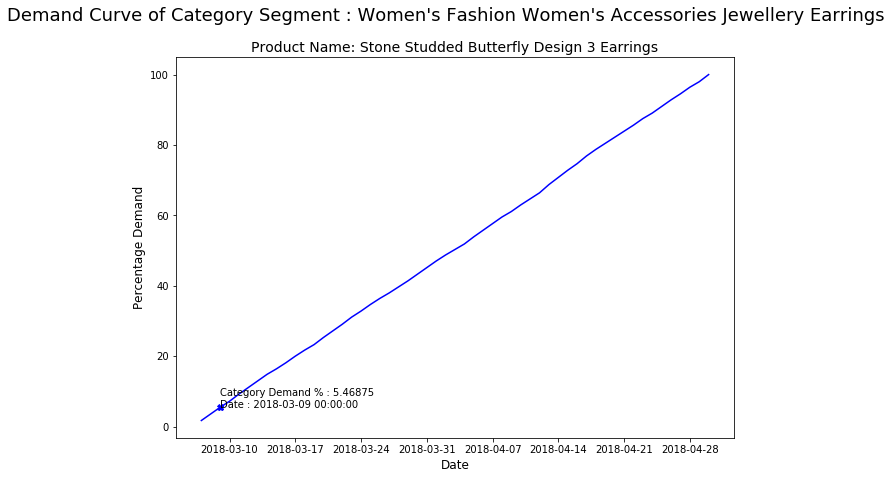

In [65]:
#from IPython.core.debugger import set_trace
getEstimatedLostSale(SKUid,PeriodStartDate,offlineStartDate,offlineDays,True)

---------------------------------------------------------------------------
SKU:  10259FA00LZEANAFAMZ  Start Date  2018-03-13  OfflineDate  2018-03-17  Offline for Days  45 Demand % :  0.08005427408412484 Total Demand when Offline :  1
Estiamted Lost Sales : 11.491525423728811


11.491525423728811

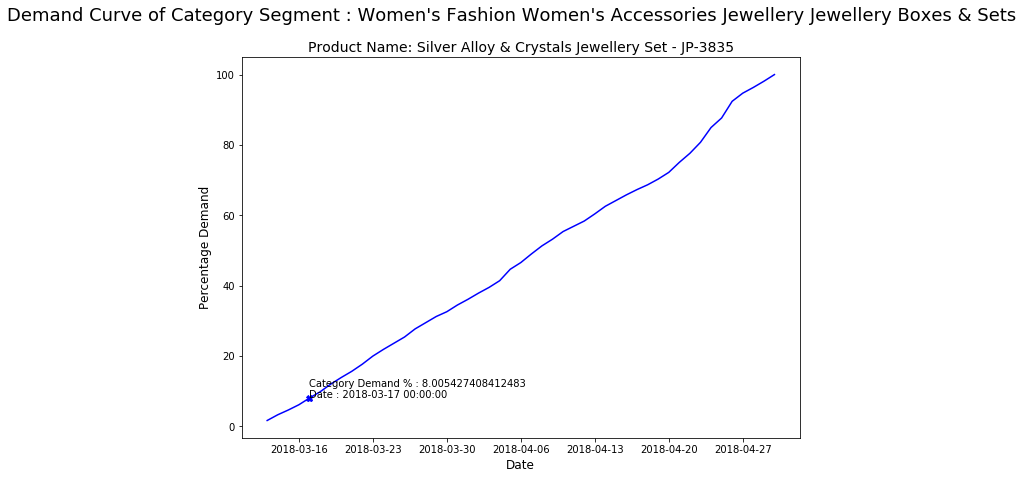

In [67]:
#from IPython.core.debugger import set_trace
getEstimatedLostSale('10259FA00LZEANAFAMZ','2018-03-13','2018-03-17',45,True)

---------------------------------------------------------------------------
SKU:  10454FA1K4RW6NAFAMZ  Start Date  2018-01-17  OfflineDate  2018-03-01  Offline for Days  1 Demand % :  0.9758551307847082 Total Demand when Offline :  1
Estiamted Lost Sales : 0.024742268041237248


0.024742268041237248

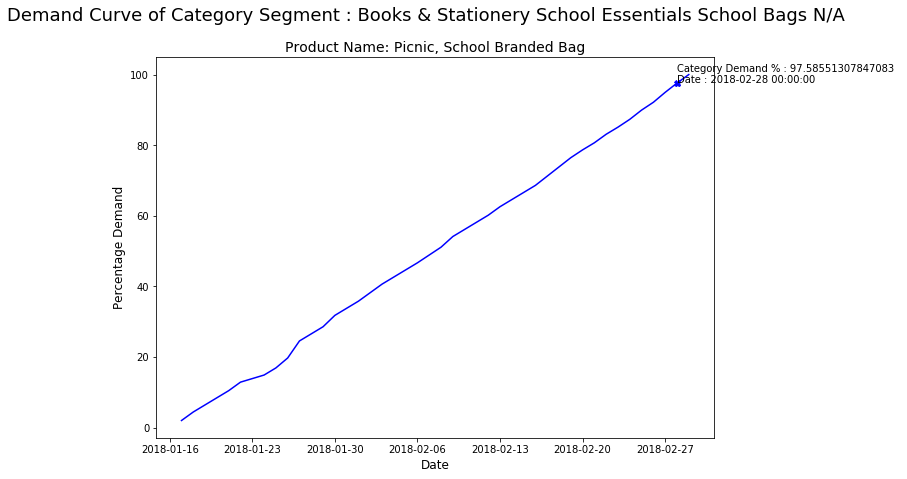

In [66]:
#from IPython.core.debugger import set_trace
getEstimatedLostSale('10454FA1K4RW6NAFAMZ','2018-01-17','2018-03-01',1,True)

In [68]:
startDate = None
previousSKU = None
currentSKU = None
estLostSale = []
endDate = None 
baseStartDate = "2017-12-01"
import time;

localtime = time.time()
print("Local current time :", localtime)
for i, row in formattedDf[:5000].iterrows():
    currentSKU = row['SKU']
    if previousSKU == None:
        previousSKU = currentSKU
    elif previousSKU != currentSKU:
        startDate = None
        previousSKU = currentSKU
        #print("SKU Changed .. Updating SKU")
    
    if startDate == None:
        startDate = datetime.strptime(baseStartDate, "%Y-%m-%d").strftime("%Y-%m-%d")
        #print("Start : ",startDate)
        endDate = datetime.strptime(row['OfflineDate'], "%Y-%m-%d") + timedelta(days=int(row['OfflineDays'])-1)
        #print("End : ", endDate)
    else:
        startDate = endDate + timedelta(days=int(1))
        #print("Start : ",startDate)
        delta = startDate - (datetime.strptime(row['OfflineDate'], "%Y-%m-%d") + timedelta(days=int(row['OfflineDays'])-1))
        delta = delta.days * -1
        #print("Delta : ", delta)
        endDate = (datetime.strptime(startDate.strftime("%Y-%m-%d"), "%Y-%m-%d") + timedelta(days=int(delta)))
        #endDate = endDate.strftime("%Y-%m-%d")
        startDate = startDate.strftime("%Y-%m-%d")
        #print("End : ", endDate)
        
    estLostSale.append(getEstimatedLostSale(row['SKU'],startDate,row['OfflineDate'],row['OfflineDays'],False))
        

    
localtime2 = time.time()
print("total time taken :", localtime2-localtime)

Local current time : 1526708429.796924
---------------------------------------------------------------------------
SKU:  00301FA0IW7BMNAFAMZ  Start Date  2018-03-04  OfflineDate  2018-03-06  Offline for Days  1 Demand % :  0.7115384615384616 Total Demand when Offline :  1
Estiamted Lost Sales : 0.40540540540540526
---------------------------------------------------------------------------
SKU:  00301FA0IW7BMNAFAMZ  Start Date  2018-03-13  OfflineDate  2018-04-05  Offline for Days  1 Demand % :  0.9561855670103094 Total Demand when Offline :  1
Estiamted Lost Sales : 0.04582210242587581
---------------------------------------------------------------------------
SKU:  00301FA0IW7BMNAFAMZ  Start Date  2018-04-20  OfflineDate  2018-04-27  Offline for Days  4 Demand % :  0.7543859649122805 Total Demand when Offline :  2
Estiamted Lost Sales : 0.6511627906976751
---------------------------------------------------------------------------
SKU:  00301FA0QSN4YNAFAMZ  Start Date  2018-02-03  Offl

In [ ]:
#facts['pop2050'] = formattedDf[:500].apply(final_pop,axis=1)


In [ ]:
def ifNumber(s):
    try: 
        float(s)
        return True
    except ValueError:
        return False

In [70]:
pd.DataFrame(estLostSale).shape
#pd.DataFrame(estLostSale).to_pickle('./lostSaleEstimates',compression='infer', protocol=4)

(5000, 1)

In [71]:
temp = pd.concat([formattedDf[:5000].reset_index(),pd.DataFrame(estLostSale).reset_index()], axis=1) 
temp.columns = ['index', 'OfflineDate', 'OfflineDays', 'SKU', 'index', 'EstLostSales']

In [73]:
temp[['SKU','EstLostSales','OfflineDate', 'OfflineDays' ]]

,SKU,EstLostSales,OfflineDate,OfflineDays
0,00301FA0IW7BMNAFAMZ,Product Offline : 2017-12-01 00:00:00 - 2018-0...,2017-12-01,75
1,00301FA0IW7BMNAFAMZ,No Demand : 2018-02-14 00:00:00 - 2018-03-01 0...,2018-03-01,1
2,00301FA0IW7BMNAFAMZ,No Demand : 2018-03-02 00:00:00 - 2018-03-03 0...,2018-03-03,1
3,00301FA0IW7BMNAFAMZ,0.405405,2018-03-06,1
4,00301FA0IW7BMNAFAMZ,No Demand : 2018-03-07 00:00:00 - 2018-03-12 0...,2018-03-10,3
5,00301FA0IW7BMNAFAMZ,0.0458221,2018-04-05,1
6,00301FA0IW7BMNAFAMZ,No Demand : 2018-04-06 00:00:00 - 2018-04-17 0...,2018-04-17,1
7,00301FA0IW7BMNAFAMZ,No Demand : 2018-04-18 00:00:00 - 2018-04-19 0...,2018-04-19,1
8,00301FA0IW7BMNAFAMZ,0.651163,2018-04-27,4
9,00301FA0QSN4YNAFAMZ,Product Offline : 2017-12-01 00:00:00 - 2018-0...,2017-12-01,35
